# Prepare Data

In [17]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Define functions

In [18]:
def base_wav(
    wave:str,
    start:float,
    end:float,
    amp:float=1,
    f:float=1,
    phase_shift:float=0,
    fs:int=1024,
):
    times = np.arange(start, end, 1/fs)
    phase = 2*np.pi*f * times
    if wave == 'sin':
        wav = amp * np.sin(phase + phase_shift)
    if wave == 'cos':
        wav = amp * np.cos(phase + phase_shift)
    return times, wav

def signal(
    start:float,
    end:float,
    amplitudes:dict,
    modes:dict,
    phases:dict,
    fs:int=1024,
):
    times = np.arange(start, end, 1/fs) 
    signal = np.zeros(len(times))
    for wave in ('sin', 'cos'):
        if len(amplitudes[wave]) != 0 \
        and len(modes[wave]) != 0 \
        and len(phases[wave]) != 0:
            for amp, f, phase_shift in zip(amplitudes[wave], modes[wave], phases[wave]):
                _, sig = base_wav(
                    wave=wave,
                    start=start,
                    end=end,
                    amp=amp,
                    f=f,
                    phase_shift=phase_shift,
                    fs=fs,
                )
                signal += sig

    return times, signal

def gaussian(
    start:float,
    end:float,
    loc:float=0,
    scale:float=1,
    fs:int=1024,
):
    times = np.arange(start, end, 1/fs)
    signal = np.random.normal(loc=loc, scale=scale, size=len(times))
    return times, signal

## Gaussian noise and glitches

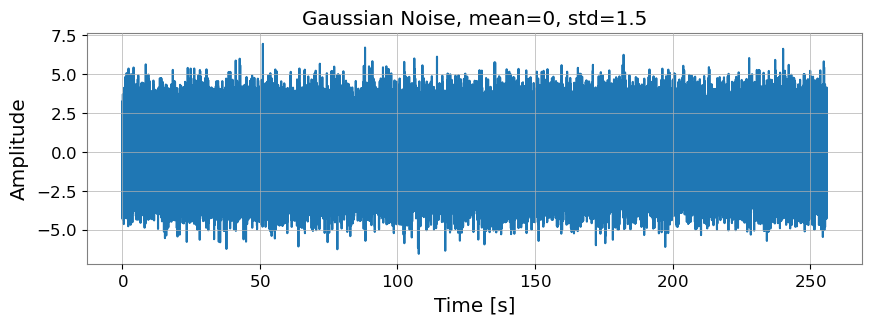

In [19]:
start = 0
end = 256
loc = 0
scale = 1.5
fs = 1024

g_times, g_noise = gaussian(
    start=start,
    end=end,
    loc=loc,
    scale=scale,
)
plt.figure(figsize=[10,3])
plt.title(f"Gaussian Noise, mean={loc}, std={scale}")
plt.plot(g_times, g_noise)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

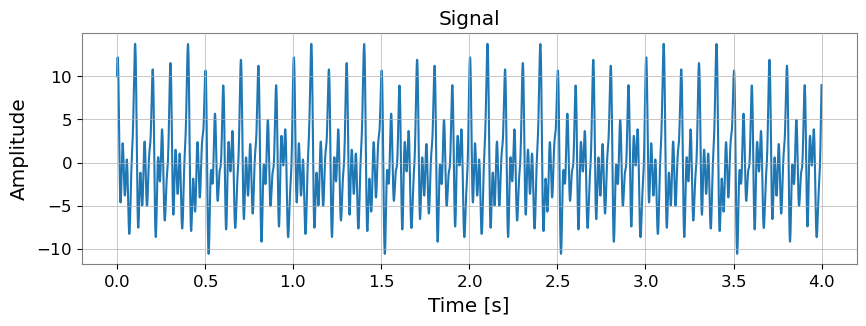

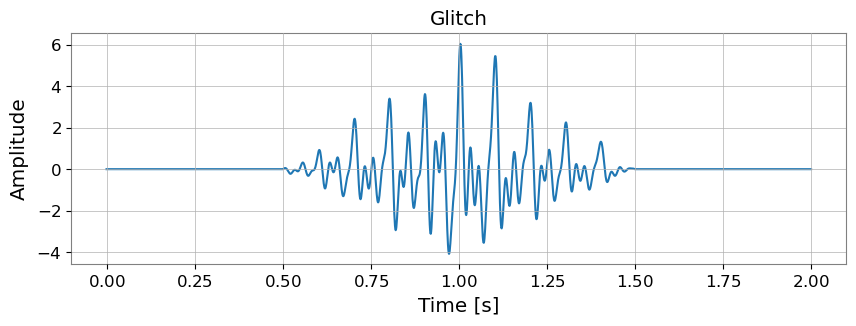

In [20]:
amplitudes = {
    "cos":[3, 5, 2],
    "sin":[1, 2, 3],
}
modes = {
    "cos":[10, 20, 30],
    "sin":[11, 13, 40],
}
phases = {
    "cos":[0, 0, 0],
    "sin":[0, 0, 0],
}

start = 0
end = 4
duration = end - start
times, sig = signal(
    start=start,
    end=end,
    amplitudes=amplitudes,
    modes=modes,
    phases=phases,
)
plt.figure(figsize=[10,3])
plt.title(f"Signal")
plt.plot(times, sig)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# # Fourier transformation
# fs = 1024
# sig_f = np.fft.rfft(sig)
# df = 1/(len(times)/fs)

# f_view = [8, 41]
# frequencies = np.arange(0, fs/2 + df, df)
# fst = int(f_view[0]/df)
# fed = int(f_view[1]/df)
# plt.figure(figsize=[10,5])
# plt.title("FFT: Amplitude")
# plt.plot(frequencies[fst:fed], np.abs(sig_f[fst:fed])/len(frequencies))
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Amplitude")
# plt.xscale('log')
# for wave in ['cos', 'sin']:
#     for amp, f in zip(amplitudes[wave], modes[wave]):
#         if amp != 0:
#             plt.axvline(f, c='red', lw=1.5, ls='--')

# plt.show()

# plt.figure(figsize=[10,5])
# plt.title("FFT: Phase")
# plt.plot(frequencies[fst:fed], np.angle(sig_f[fst:fed]))
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Phase")
# plt.xscale('log')
# for wave in ['cos', 'sin']:
#     for amp, f in zip(amplitudes[wave], modes[wave]):
#         if amp != 0:
#             plt.axvline(f, c='red', lw=1.5, ls='--')

# plt.show()

# Creating glitch time series data
fs = 1024
glitch_st = duration/2 - 0.5
glitch_ed = glitch_st + 1
pad_head = 0.5
pad_tail = 0.5
_ , glitch = signal(
    start=glitch_st,
    end=glitch_ed,
    amplitudes=amplitudes,
    modes=modes,
    phases=phases,
)
glitch_times = np.arange(0, 2, 1/fs) 
window = np.bartlett(len(glitch))
glitch *= window
pad_earlier = int(pad_head*fs)
pad_later = int(pad_tail*fs)
pad_width = (pad_earlier, pad_later)
glitch = np.pad(glitch, pad_width=pad_width, mode='constant', constant_values=(0,0))
glitch *= 0.5
plt.figure(figsize=[10,3])
plt.title(f"Glitch")
plt.plot(glitch_times, glitch)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()


## Injection of glitches

29
[129, 139, 141, 143, 145, 147, 149, 151, 153, 155, 159, 171, 175, 179, 183, 189, 193, 199, 207, 213, 215, 217, 225, 231, 235, 237, 241, 245, 247]


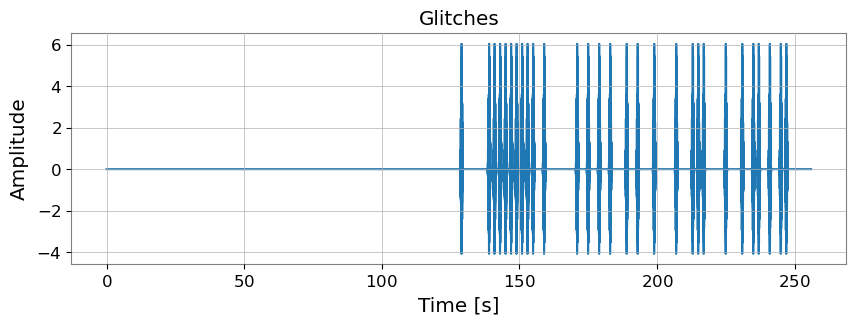

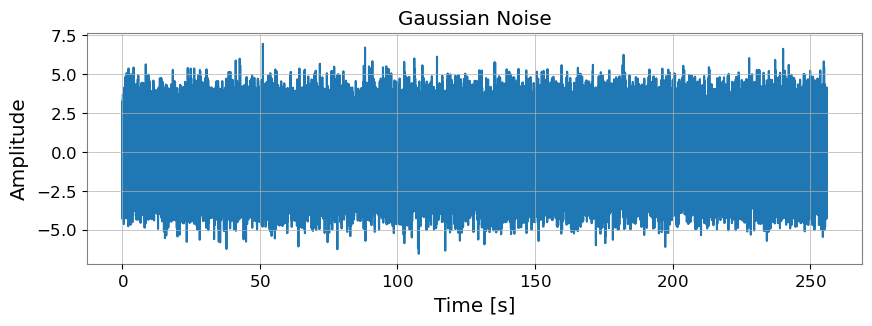

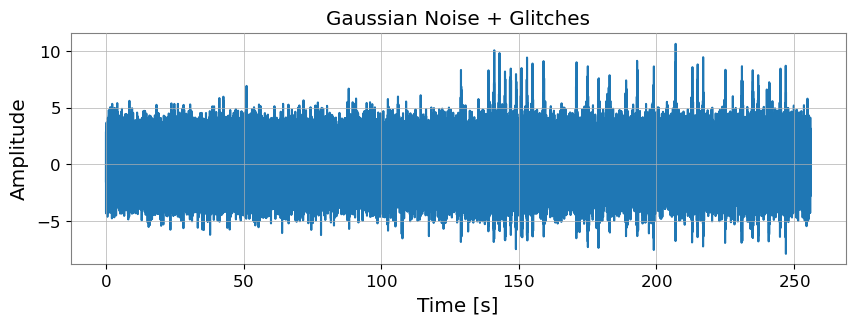

In [21]:
# Sampling the time to inject glitches
np.random.seed(2617)
glitch_n = int(len(g_noise)/fs/2)
glitch_inj = np.random.randint(0, 2, glitch_n)
for i, _ in enumerate(glitch_inj[:64]):
    glitch_inj[i] = 0

glitch_time_labels = []
if glitch_inj[0] == 1:
    glitches = glitch
    glitch_time_labels.append(0+1)
else:
    glitches = np.zeros(2*fs)

for i, inj in enumerate(glitch_inj[1:]):
    if inj == 1:
        glitches = np.append(glitches, glitch)
        glitch_time_labels.append((i+1)*2 + 1)
    else:
        glitches = np.append(glitches, np.zeros(2*fs))

print(len(glitch_time_labels))
print(glitch_time_labels)
plt.figure(figsize=[10,3])
plt.title(f"Glitches")
plt.plot(g_times, glitches)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=[10,3])
plt.title(f"Gaussian Noise")
plt.plot(g_times, g_noise)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

noise = g_noise + glitches
plt.figure(figsize=[10,3])
plt.title(f"Gaussian Noise + Glitches")
plt.plot(g_times, noise)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Save time series data

In [24]:
from gwpy.timeseries import TimeSeries

In [25]:
# Create gwpy TimeSeries
t0 = 1234567890
sample_rate = fs
duration = int(len(g_noise)/fs)
g_noise_ts = TimeSeries(
    g_noise,
    t0=t0,
    sample_rate=sample_rate,
    channel="EX:GAUSSIAN_EXAMPLE",
    name="EX:GAUSSIAN_EXAMPLE",
)
noise_ts = TimeSeries(
    noise,
    t0=t0,
    sample_rate=sample_rate,
    channel="EX:NOISE_EXAMPLE",
    name="EX:NOISE_EXAMPLE",
)

# Save data to gwf files
g_noise_ts.write(f"./Data/EX-GAUSSIAN-{t0}-{duration}.gwf")
noise_ts.write(f"./Data/EX-NOISE-{t0}-{duration}.gwf")

## Check triggers

In [26]:
import h5py 
import glob

In [27]:
# Check Gaussian noise
h5s = glob.glob("/home/jerry/GW/glitch-classification/Omicron/triggers/EX:GAUSSIAN_EXAMPLE/*.h5")
h5s = sorted(h5s)
triggers = []
for h5 in h5s[:]:
    with h5py.File(h5, 'r') as f:
        # print(f.keys())
        # print(f['triggers'])
        triggers.extend(f['triggers'][:])

# Check how many triggers are reported
print(len(triggers))
# Check one of the triggers
# id = 0
# print(triggers[id].dtype)
# print(f"time: {triggers[id]['time']}")
# print(f"frequency: {triggers[id]['frequency']}")
# print(f"q: {triggers[id]['q']}")
# print(f"snr: {triggers[id]['snr']}")
# # Check the time of all triggers
# trigger_times = [trigger['time'] for trigger in triggers]
# print(trigger_times)
# Plot Gaussian time series data
# g_noise_ts.plot().show()

7


35
{'names': ['time', 'frequency', 'tstart', 'tend', 'fstart', 'fend', 'snr', 'q', 'amplitude', 'phase'], 'formats': ['<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8'], 'offsets': [0, 8, 48, 56, 64, 72, 16, 24, 32, 40], 'itemsize': 80}
time: 1234567952.316406
frequency: 384.8859797475013
q: 37.98442282046881
snr: 5.128369805670171
[1234567952.316406, 1234567969.072265, 1234568019.0625, 1234568020.646484, 1234568029.0625, 1234568030.9375, 1234568032.9375, 1234568034.9375, 1234568037.0625, 1234568038.9375, 1234568040.9375, 1234568043.0625, 1234568045.0625, 1234568048.9375, 1234568061.0625, 1234568065.0625, 1234568069.0625, 1234568072.9375, 1234568079.0625, 1234568081.576172, 1234568083.0625, 1234568088.172851, 1234568089.0625, 1234568096.9375, 1234568103.0625, 1234568105.0625, 1234568107.0625, 1234568114.9375, 1234568121.0625, 1234568125.0625, 1234568126.9375, 1234568131.0625, 1234568134.9375, 1234568137.0625, 1234568143.626953]


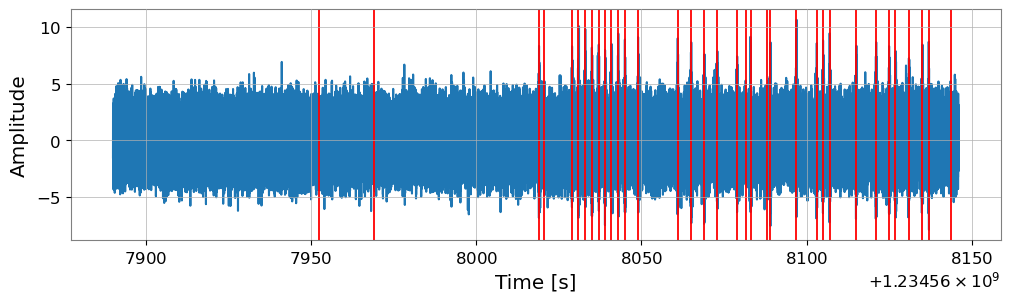

In [28]:
# Check noise with glitches
h5s = glob.glob("/home/jerry/GW/glitch-classification/Omicron/triggers/EX:NOISE_EXAMPLE/*.h5")
h5s = sorted(h5s)
triggers = []
for h5 in h5s[:]:
    with h5py.File(h5, 'r') as f:
        # print(f.keys())
        # print(f['triggers'])
        triggers.extend(f['triggers'][:])

# Check how many triggers are reported
print(len(triggers))
# Check one of the triggers
id = 0
print(triggers[id].dtype)
print(f"time: {triggers[id]['time']}")
print(f"frequency: {triggers[id]['frequency']}")
print(f"q: {triggers[id]['q']}")
print(f"snr: {triggers[id]['snr']}")
# Check the time of all triggers
trigger_times = [trigger['time'] for trigger in triggers]
print(trigger_times)
# Plot noise time series data
# noise_ts.plot().show()

plt.figure(figsize=[12,3])
plt.plot(noise_ts.times, noise_ts)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
for t in trigger_times:
    plt.axvline(t, c='r', lw=1.3)
plt.show()

In [29]:
inj_glitch_times = np.array(glitch_time_labels)
inj_glitch_times += 1234567890
print(len(inj_glitch_times))
print(inj_glitch_times)

29
[1234568019 1234568029 1234568031 1234568033 1234568035
 1234568037 1234568039 1234568041 1234568043 1234568045
 1234568049 1234568061 1234568065 1234568069 1234568073
 1234568079 1234568083 1234568089 1234568097 1234568103
 1234568105 1234568107 1234568115 1234568121 1234568125
 1234568127 1234568131 1234568135 1234568137]
